# Understanding precipitation variability under climate change

This notebook creates a figure of precip changes (both mean and variability) as a function of GMST. It essentially replicates Figure 3 in [this paper](https://www.nature.com/articles/s41598-017-17966-y). It was a product of the NCAR CMIP6 Hackathon Oct 16-18, 2019.

Authors:
- Angeline Pendergrass, NCAR
- Chiara Lepore, LDEO
- Kevin Schwarzwald, Columbia Univ.
- Ian Bolliger, UC Berkeley

Currently, this is designed to work using the environment specified in the `environment.yml` file contained in this repo, on either the NCAR supercomputing infrastructure or on [ocean.pangeo.io](ocean.pangeo.io)

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
# import gcsfs
# from tqdm.autonotebook import tqdm
from scipy import signal
import util

/glade/u/home/bolliger/.local/lib/python3.7/site-packages/intake/source/discovery.py:136: FutureWarning: The drivers ['stac-catalog', 'stac-collection', 'stac-item'] do not specify entry_points and were only discovered via a package scan. This may break in a future release of intake. The packages should be updated.
  FutureWarning)


In [2]:
# Experiments to process
experiment_ids = ['historical', 'ssp370']

# Seasons to process
seasons = ['all','DJF','JJA']

# total time range of assets we would need
time_range = [1976, 2100]

# Time slices (future) to process
time_slices = ([['1991','2020'],
                ['2001','2030'],
                ['2011','2040'],
                ['2021','2050'],
                ['2031','2060'],
                ['2041','2070'],
                ['2051','2080'],
                ['2061','2090'],
                ['2071','2100']])

# variables we need to aggregate
# (huss for ssp370 not available on cloud yet
# (so we will skip)
variable_ids = ['pr','tas']
if util.is_ncar_host():
    variable_ids.append('huss')

# tables needed
table_ids = ['Amon']

# temporally constant vars needed for aggregation
const_vars = ['sftlf','areacella']

## Finding data

First, we get a list of all the data assets we will need to read in for this analysis.

In [3]:
col = util.load_data_catalog()

In [4]:
# subset to overall things we're looking at
subset = col.search(experiment_id=experiment_ids, 
                    variable_id=variable_ids,
                    table_id=table_ids)

In [5]:
# subset to models that have all the variables we want
# (monthly tas, pr, huss) for both historical and ssp370
uni_dict = subset.unique(['source_id','table_id','variable_id'])
models = set(uni_dict['source_id']['values']) # all the models
for v in variable_ids:
    for e in experiment_ids:
        cat = subset.search(variable_id=v, experiment_id=e)
        models = models.intersection({model for model in cat.df.source_id.unique().tolist()})

models = list(models)

# subset to relevant models
col_vars = subset.search(source_id=models)

In [6]:
## subset on years
model_df = col_vars.df.copy()

# clean up dates
years = model_df.time_range.str.split('-', expand=True).apply(lambda ser: ser.str[:4]).astype(int)

# subset
valid = ((years[0]>= time_range[0]) & (years[0] <= time_range[1]) | 
         (years[1]>= time_range[0]) & (years[1] <= time_range[1]))

# return to our collection
col_vars.df = model_df[valid]

In [7]:
## get all the appropriate constant assets

# subset full collection to models we're using
models = col_vars.unique('source_id')['source_id']['values']
subset_const = col.search(source_id=models, variable_id=const_vars)

# subset to models that have all the variables we want
# (monthly tas, pr, huss)
uni_dict = subset_const.unique(['source_id','variable_id'])
models_const = set(uni_dict['source_id']['values']) # all the models
for v in const_vars:
    cat = col.search(variable_id=v)
    models_const = models_const.intersection({model for model in cat.df.source_id.unique().tolist()})

models = list(models_const)

# subset to relevant models
col_const = subset_const.search(source_id=models)

Finding fixed grid assets to use for our models. **NOTE (IB, 10/17/19)**: For now, I'm assuming that any grid with the same `grid_label` and `source_id` will be the same. Hopefully this is true. This is to avoid the complicated fuzzy matching algorithm needed to deal with the varied ways in which modeling groups save `fx` tables.

In [8]:
single_const_df = col_const.df.copy().groupby(['source_id','grid_label','variable_id']).first().reset_index()
col_const.df = single_const_df

**NOTE (IB, 10/17/19)**: Here I am subsetting to only the models that have `areacella` and `sftlf`. I'm hoping that we'll have that data at some point for all models, so am not going through the logistical challenge of calculating these values for models that don't have them. If we need to, we can do that at some point

In [9]:
col_vars = col_vars.search(source_id=models)

Now, back to our regularly scheduled programming...

First, load dask cluster to deal with large data

In [13]:
if util.is_ncar_host():
    from ncar_jobqueue import NCARCluster
    cluster = NCARCluster(project='UCGD0006')
    cluster.adapt(minimum_jobs=1, maximum_jobs=10)
else:
    from dask_kubernetes import KubeCluster
    cluster = KubeCluster()
    cluster.adapt(minimum=1, maximum=10)
cluster

In [14]:
from dask.distributed import Client
client = Client(cluster) # Connect this local process to remote workers
client

Client Scheduler: tcp://128.117.181.227:36427 Dashboard: https://jupyterhub.ucar.edu/dav/user/bolliger/proxy/8787/status,Cluster Workers: 1 Cores: 1 Memory: 25.00 GB


Here's where everything started breaking... I thought it was a memory issue, but dask didn't help. I think it's a bug in `intake-esm` and/or CESM (see my slack note). Everything but CESM works, so I just drop CESM for now.

In [31]:
non_cesm = col_vars.search(source_id = [
    m for m in col_vars.unique('source_id')['source_id']['values'] 
    if 'CESM' not in m])
non_cesm_dict = non_cesm.to_dataset_dict(
    preprocess=lambda x: x.drop_dims('bnds', errors='ignore'))


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 14 group(s)


Take seasonal means and means over ensemble

In [72]:
for grp, this_ds in non_cesm_dict.items():
    non_cesm_dict[grp] = (this_ds[variable_ids].mean('member_id') # average across ensembles
               .groupby('time.season').mean() # seasonal average
               .persist()) # load this data with dask

distributed.utils - ERROR - 
Traceback (most recent call last):
  File "/glade/u/home/bolliger/miniconda3/envs/CMIP6-201910-precip/lib/python3.7/site-packages/distributed/utils.py", line 662, in log_errors
    yield
  File "/glade/u/home/bolliger/miniconda3/envs/CMIP6-201910-precip/lib/python3.7/site-packages/distributed/scheduler.py", line 3146, in retire_workers
    delete=False,
  File "/glade/u/home/bolliger/miniconda3/envs/CMIP6-201910-precip/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/glade/u/home/bolliger/miniconda3/envs/CMIP6-201910-precip/lib/python3.7/site-packages/distributed/scheduler.py", line 2910, in replicate
    assert count > 0
AssertionError
distributed.core - ERROR - 
Traceback (most recent call last):
  File "/glade/u/home/bolliger/miniconda3/envs/CMIP6-201910-precip/lib/python3.7/site-packages/distributed/core.py", line 403, in handle_comm
    result = await result
  File "/glade/u/home/bolliger/minicon

Now aggregate the historical and ssp370 data scross models

In [57]:
ds_agg = {}
for i in experiment_ids:
    ds_agg[i] = xr.concat([v for k,v in non_cesm_dict.items() 
                           if i in k],dim='source_id')

RecursionError: maximum recursion depth exceeded while calling a Python object

In [ ]:
dict_vars = col_vars.to_dataset_dict(preprocess=lambda x: x.drop(['lat_bnds','lon_bnds']))


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 18 group(s)


In [115]:
col_historical = col_vars.search(experiment_id='historical')
dict_historical = col_historical.to_dataset_dict(preprocess=lambda x: x.drop(['lat_bnds','lon_bnds']))


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 16 group(s)


KilledWorker: ('_load_group_dataset-adc3dc17-0c3f-40c0-a3a2-f8352260d115', <Worker 'tcp://10.148.10.173:44153', memory: 0, processing: 16>)

In [109]:
col_pr = col_vars.search(variable_id='pr')
col_tas = col_vars.search(variable_id='tas')
col_huss = col_vars.search(variable_id='huss')

In [117]:
dict_pr_hist = col_pr.search(experiment_id='historical').to_dataset_dict(preprocess=lambda x: x[['pr']])


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 16 group(s)


KilledWorker: ('_load_group_dataset-f1609f98-bd69-47dc-b3f1-bc247de0fee1', <Worker 'tcp://10.148.10.173:35807', memory: 0, processing: 16>)

In [41]:
dict_tas['AerChemMIP.BCC.BCC-ESM1.ssp370.Amon.gn'].bnds

<xarray.DataArray 'bnds' (bnds: 2)>
array([0, 1])
Dimensions without coordinates: bnds

In [39]:
dict_tas = col_tas.to_dataset_dict()


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 17 group(s)


/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'tas' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: S

In [25]:
dict_pr = col_pr.to_dataset_dict()


xarray will load netCDF datasets with dask using a single chunk for all arrays.
For effective chunking, please provide chunks in cdf_kwargs.
For example: cdf_kwargs={'chunks': {'time': 36}}

--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'

--> There will be 17 group(s)


/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: SerializationWarning: variable 'pr' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  use_cftime=use_cftime,
/ncar/usr/jupyterhub/envs/cmip6-201910a/lib/python3.7/site-packages/xarray/conventions.py:494: Seria

In [34]:
for m in dict_pr

dict_pr['AerChemMIP.BCC.BCC-ESM1.ssp370.Amon.gn'].mean(dim='member_id')

<xarray.Dataset>
Dimensions:   (bnds: 2, lat: 64, lon: 128, time: 492)
Coordinates:
  * lon       (lon) float64 0.0 2.812 5.625 8.438 ... 348.8 351.6 354.4 357.2
  * lat       (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * time      (time) object 2015-01-16 12:00:00 ... 2055-12-16 12:00:00
Dimensions without coordinates: bnds
Data variables:
    lat_bnds  (lat, bnds) float64 dask.array<chunksize=(64, 2), meta=np.ndarray>
    lon_bnds  (lon, bnds) float64 dask.array<chunksize=(128, 2), meta=np.ndarray>
    pr        (time, lat, lon) float32 dask.array<chunksize=(492, 64, 128), meta=np.ndarray>

In [ ]:
dict_pr['AerChemMIP.BCC.BCC-ESM1.ssp370.Amon.gn'].mean

In [13]:
# Function to load data: df_data has the catalogue of the variable of interest
def load_data(df_data, source_id, expt_id):
    """
    Load data for given variable, source and expt ids.
    """
    uri = df_data[(df_data.source_id == source_id) &
                  (df_data.experiment_id == expt_id)].zstore.values[0]
    
    gcs = gcsfs.GCSFileSystem(token='anon')
    ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
    return ds

In [14]:
# # Function to load precipitation data
# def load_tas_data(source_id, expt_id):
#     """
#     Load tas data for given source and expt ids
#     """
#     uri = df_mon_tas[(df_mon_tas.source_id == source_id) &
#                          (df_mon_tas.experiment_id == expt_id)].zstore.values[0]
    
#     gcs = gcsfs.GCSFileSystem(token='anon')
#     ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
#     return ds

In [15]:
# Function to get mean and variability and their changes
def mean_dtas_calc(data_tmp,seas='all', weights_in=None):
    # Set if season is 'all'
    if seas=="all":
        seas = ['DJF','MAM','JJA','SON']
    
    # Load
    mu_hist = data_tmp['hist'].load()
    mu_futr = data_tmp['futr'].load()
    
        
    # Calculate mean of raw series
    mu_hist = (data_tmp['hist'].sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .tas.mean('time'))
    mu_futr = (data_tmp['futr'].sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .tas.mean('time'))
    if weights_in is not None:
        weights = weights_in.areacella
        mu_histG = np.average(mu_hist,weights=weights)
        mu_futrG = np.average(mu_futr,weights=weights)
    else:
        # Area weighting
        latr = np.deg2rad(data_tmp['hist'].lat)
        # Use the cosine of the converted latitudes as weights for the average
        weights = np.cos(latr)
        mu_histG = np.average(mu_hist.mean("lon"),weights=weights)
        mu_futrG = np.average(mu_futr.mean("lon"),weights=weights)
        
    dtasG = mu_futrG-mu_histG
#    dmu = mu_futr/mu_hist
#    dmuG = np.average(dmu.mean("lon"),weights=weights.values)

    # Out 
    outp = xr.Dataset(
        data_vars = {#'tas_hist': tas_hist,
                     #'tas_futr': tas_futr,
                     #'dmu':     dmu,
                     'dtasG':    ([],dtasG)}

        #coords={'lon':            (['lon'],results_tmp['hist'].lon),
        #        'lat':             (['lat'],results_tmp['hist'].lat)}
        )


    return(outp)

In [45]:

tdata = {}
tresults = {}

for mod_name in tqdm(source_ids):
    # get a 20 year period
    # try:
        print('\n\nStarting '+mod_name+'\n')
        ds_hist = load_data(df_mon_tas, mod_name, experiment_ids[0]).sel(time=slice('1976', '2005'))
        ds_ssp  = load_data(df_mon_tas, mod_name, experiment_ids[1])
        
        try: # try getting areacella data
            ds_areacella = load_data(df_areacella, mod_name, experiment_ids[0])

        except: #if not available, flag it as 0. It will use np.cos(lat)
            ds_areacella = None
        
        tdata[mod_name] = {}
        tresults[mod_name] = {}
        
        for time_slice in time_slices:
            print('Begin processing time slice '+time_slice[0]+'-'+time_slice[1])
            if ds_ssp.time.max().dt.year+1<int(time_slice[1]):
                print("Future time series only goes until "+str(ds_ssp.time.max().dt.year.values))
                break
            
            # Get corresponding temporal slice of data and stage it
            ds_ssp_tmp = ds_ssp.sel(time=slice(time_slice[0],time_slice[1]))
            tdata[mod_name]["t"+time_slice[0]] = {'hist':ds_hist,'futr':ds_ssp_tmp}
            
            
            tresults[mod_name]["t"+time_slice[0]] = {}
           # Calculate means, sds,...
            tresults[mod_name]['t'+time_slice[0]] = mean_dtas_calc(tdata[mod_name]['t'+time_slice[0]],
                                                                   seas = 'all', weights_in=ds_areacella)
            print(' processed!')
                
            print(time_slice[0]+'-'+time_slice[1]+' processed!')
            
        print(mod_name+' processed!')
    #except:
    #    print(mod_name+"broken")



Starting BCC-ESM1

Begin processing time slice 2011-2040
 processed!
2011-2040 processed!
Begin processing time slice 2021-2050
 processed!
2021-2050 processed!
Begin processing time slice 2031-2060
Future time series only goes until 2055
BCC-ESM1 processed!


Starting CanESM5

Begin processing time slice 2011-2040
 processed!
2011-2040 processed!
Begin processing time slice 2021-2050
 processed!
2021-2050 processed!
Begin processing time slice 2031-2060
 processed!
2031-2060 processed!
Begin processing time slice 2041-2070
 processed!
2041-2070 processed!
Begin processing time slice 2051-2080
 processed!
2051-2080 processed!
Begin processing time slice 2061-2090
 processed!
2061-2090 processed!
Begin processing time slice 2071-2100
 processed!
2071-2100 processed!
CanESM5 processed!


Starting GFDL-ESM4

Begin processing time slice 2011-2040
 processed!
2011-2040 processed!
Begin processing time slice 2021-2050
 processed!
2021-2050 processed!
Begin processing time slice 2031-2060
 

In [46]:
pd.DataFrame(tresults)

,BCC-ESM1,CanESM5,GFDL-ESM4,CAMS-CSM1-0,IPSL-CM6A-LR,CESM2-WACCM,BCC-CSM2-MR,MIROC6,CESM2,MRI-ESM2-0
t2011,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2021,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2031,NaN,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2041,NaN,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2051,NaN,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2061,NaN,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]
t2071,NaN,[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG],[dtasG]


In [47]:
tresults_new=tresults
for model in tresults:
    for timeperiod in tresults[model]:
        tresults_new[model][timeperiod]=tresults_new[model][timeperiod].dtasG.values.item(0)


In [48]:
tresults_new

{'BCC-ESM1': {'t2011': 1.0801761490631065, 't2021': 1.2820887939342356},
 'CanESM5': {'t2011': 1.43841552734375,
  't2021': 1.863525390625,
  't2031': 2.394561767578125,
  't2041': 2.99609375,
  't2051': 3.5789794921875,
  't2061': 4.184478759765625,
  't2071': 4.7864990234375},
 'GFDL-ESM4': {'t2011': 0.812835693359375,
  't2021': 1.0216064453125,
  't2031': 1.295166015625,
  't2041': 1.63104248046875,
  't2051': 2.001800537109375,
  't2061': 2.39813232421875,
  't2071': 2.761627197265625},
 'CAMS-CSM1-0': {'t2011': 0.5855764510201311,
  't2021': 0.772981770688375,
  't2031': 0.9939430476181315,
  't2041': 1.2723319490262384,
  't2051': 1.5313122272233954,
  't2061': 1.8341181418410883,
  't2071': 2.1015741747082757},
 'IPSL-CM6A-LR': {'t2011': 1.021453857421875,
  't2021': 1.34625244140625,
  't2031': 1.789947509765625,
  't2041': 2.24884033203125,
  't2051': 2.722991943359375,
  't2061': 3.22271728515625,
  't2071': 3.82684326171875},
 'CESM2-WACCM': {'t2011': 1.0078125,
  't2021': 

In [49]:
pd.DataFrame(tresults_new).to_csv('tresults.csv')

In [50]:
tresults_new=pd.read_csv('tresults.csv',index_col=0)
tresults_new

,BCC-ESM1,CanESM5,GFDL-ESM4,CAMS-CSM1-0,IPSL-CM6A-LR,CESM2-WACCM,BCC-CSM2-MR,MIROC6,CESM2,MRI-ESM2-0
t2011,1.080176,1.438416,0.812836,0.585576,1.021454,1.007812,0.964405,0.697571,1.094421,1.023926
t2021,1.282089,1.863525,1.021606,0.772982,1.346252,1.271332,1.241890,0.924072,1.337646,1.267822
t2031,NaN,2.394562,1.295166,0.993943,1.789948,1.642242,1.599642,1.235840,1.657043,1.614258
t2041,NaN,2.996094,1.631042,1.272332,2.248840,2.098663,1.969405,1.533264,2.027405,1.980377
t2051,NaN,3.578979,2.001801,1.531312,2.722992,2.548523,2.325534,1.861328,2.485107,2.343811
t2061,NaN,4.184479,2.398132,1.834118,3.222717,3.027191,2.711012,2.143311,3.025238,2.689697
t2071,NaN,4.786499,2.761627,2.101574,3.826843,3.494812,3.085562,2.475281,3.541107,3.042175


In [51]:
tresults_dict=tresults_new.to_dict()

In [52]:
dt=np.zeros((len(time_slices),len(tresults_dict)))*np.nan 

In [53]:
modelcount=0
modelnames=[]
for model in tresults_dict:
    modelnames.append(model)
    timecount=0
    for timeperiod in tresults_dict[model]:
        dt[timecount,modelcount]=tresults_dict[model][timeperiod]
        timecount=timecount+1
    modelcount=modelcount+1

In [54]:
dt

array([[1.08017615, 1.43841553, 0.81283569, 0.58557645, 1.02145386,
        1.0078125 , 0.96440512, 0.6975708 , 1.09442139, 1.02392578],
       [1.28208879, 1.86352539, 1.02160645, 0.77298177, 1.34625244,
        1.27133179, 1.24188957, 0.92407227, 1.33764648, 1.26782227],
       [       nan, 2.39456177, 1.29516602, 0.99394305, 1.78994751,
        1.64224243, 1.59964209, 1.23583984, 1.65704346, 1.61425781],
       [       nan, 2.99609375, 1.63104248, 1.27233195, 2.24884033,
        2.09866333, 1.96940471, 1.53326416, 2.02740479, 1.9803772 ],
       [       nan, 3.57897949, 2.00180054, 1.53131223, 2.72299194,
        2.54852295, 2.32553355, 1.86132812, 2.48510742, 2.34381104],
       [       nan, 4.18447876, 2.39813232, 1.83411814, 3.22271729,
        3.02719116, 2.71101181, 2.14331055, 3.02523804, 2.68969727],
       [       nan, 4.78649902, 2.7616272 , 2.10157417, 3.82684326,
        3.49481201, 3.08556153, 2.47528076, 3.54110718, 3.04217529]])

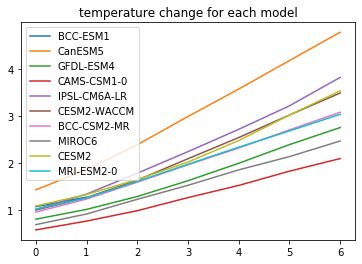

In [55]:
plt.plot(dt)
plt.title('temperature change for each model')
plt.legend(modelnames)

In [56]:
# # Function to load precipitation data
# def load_pr_data(source_id, expt_id):
#     """
#     Load precip data for given source and expt ids
#     """
#     uri = df_mon_pr[(df_mon_pr.source_id == source_id) &
#                          (df_mon_pr.experiment_id == expt_id)].zstore.values[0]
    
#     gcs = gcsfs.GCSFileSystem(token='anon')
#     ds = xr.open_zarr(gcs.get_mapper(uri), consolidated=True)
#     return ds

In [57]:
# # Function to get mean and variability and their changes
# def mean_var_calc_old(data_tmp,seas='all'):
#     # Set if season is 'all'
#     if seas=="all":
#         seas = ['DJF','MAM','JJA','SON']
    
#     # Load
#     mu_hist = data_tmp['hist'].load()
#     mu_futr = data_tmp['futr'].load()
    
#     # Area weighting
#     latr = np.deg2rad(data_tmp['hist'].lat)
#     # Use the cosine of the converted latitudes as weights for the average
#     weights = np.cos(latr)

#     # Calculate mean of raw series
#     mu_hist = (data_tmp['hist'].sel(time=data_tmp['hist'].time.dt.season.isin(seas))
#                .pr.mean('time'))
#     mu_futr = (data_tmp['futr'].sel(time=data_tmp['futr'].time.dt.season.isin(seas))
#                .pr.mean('time'))
#     mu_histG = np.average(mu_hist.mean("lon"),weights=weights.values)
#     mu_futrG = np.average(mu_futr.mean("lon"),weights=weights.values)
#     dmuG = mu_futrG/mu_histG
# #    dmu = mu_futr/mu_hist
# #    dmuG = np.average(dmu.mean("lon"),weights=weights.values)

#     # Calculate standard deviation of detrended series
#     sd_hist = (xr.apply_ufunc(signal.detrend, data_tmp['hist'].fillna(0),
#                                     kwargs={'axis': 0}).where(~data_tmp['hist'].isnull())
#                .sel(time=data_tmp['hist'].time.dt.season.isin(seas))
#                .std("time"))
#     sd_futr = (xr.apply_ufunc(signal.detrend, data_tmp['futr'].fillna(0),
#                                     kwargs={'axis': 0}).where(~data_tmp['futr'].isnull())
#                .sel(time=data_tmp['futr'].time.dt.season.isin(seas))
#                .std("time"))
#     var_hist = sd_hist ** 2
#     var_histG = np.average(var_hist.mean("lon").pr,weights=weights.values)
#     sd_histG = np.sqrt(var_histG)
#     var_futr = sd_futr ** 2
#     var_futrG = np.average(var_futr.mean("lon").pr,weights=weights.values)
#     sd_futrG = np.sqrt(var_futrG)
#     dsd = sd_futr/sd_hist
#     dsdG = sd_futrG/sd_histG

#     # Out 
#     outp = xr.Dataset(
#         data_vars = {'mu_hist': mu_hist,
#                      'mu_futr': mu_futr,
#                      #'dmu':     dmu,
#                      'dmuG':    ([],dmuG),
#                      'sd_hist': sd_hist.pr,
#                      'sd_futr': sd_futr.pr,
#                      #'dsd':     dsd.pr,
#                      'dsdG':    ([],dsdG)},
#         #coords={'lon':            (['lon'],results_tmp['hist'].lon),
#         #        'lat':             (['lat'],results_tmp['hist'].lat)}
#         )


#     return(outp)

In [ ]:
# data = {}
# results = {}

# for mod_name in tqdm(source_ids):
#     # get a 20 year period
#     # try:
#         print('\n\nStarting '+mod_name+'\n')
#         ds_hist = load_data(df_mon_pr, mod_name, experiment_ids[0]).sel(time=slice('1976', '2005'))
#         ds_ssp  = load_data(df_mon_pr, mod_name, experiment_ids[1])
        
#         data[mod_name] = {}
#         results[mod_name] = {}
        
#         for time_slice in time_slices:
#             print('Begin processing time slice '+time_slice[0]+'-'+time_slice[1])
#             if ds_ssp.time.max().dt.year+1<int(time_slice[1]):
#                 print("Future time series only goes until "+str(ds_ssp.time.max().dt.year.values))
#                 break
            
#             # Get corresponding temporal slice of data and stage it
#             ds_ssp_tmp = ds_ssp.sel(time=slice(time_slice[0],time_slice[1]))
#             data[mod_name]["t"+time_slice[0]] = {'hist':ds_hist,'futr':ds_ssp_tmp}
            
            
#             results[mod_name]["t"+time_slice[0]] = {}
#             for seas in seasons:
#                 # Calculate means, sds,...
#                 results[mod_name]['t'+time_slice[0]][seas] = mean_var_calc_old(data[mod_name]['t'+time_slice[0]],seas)
#                 print(seas+' processed!')
                
#             print(time_slice[0]+'-'+time_slice[1]+' processed!')
            
#         print(mod_name+' processed!')
#     #except:
#     #    print(mod_name+"broken")



Starting BCC-ESM1

Begin processing time slice 2011-2040
all processed!
DJF processed!
JJA processed!
2011-2040 processed!
Begin processing time slice 2021-2050
all processed!
DJF processed!
JJA processed!
2021-2050 processed!
Begin processing time slice 2031-2060
Future time series only goes until 2055
BCC-ESM1 processed!


Starting CanESM5

Begin processing time slice 2011-2040
all processed!
DJF processed!
JJA processed!
2011-2040 processed!
Begin processing time slice 2021-2050
all processed!
DJF processed!
JJA processed!
2021-2050 processed!
Begin processing time slice 2031-2060
all processed!
DJF processed!
JJA processed!
2031-2060 processed!
Begin processing time slice 2041-2070
all processed!
DJF processed!
JJA processed!
2041-2070 processed!
Begin processing time slice 2051-2080
all processed!
DJF processed!
JJA processed!
2051-2080 processed!
Begin processing time slice 2061-2090
all processed!
DJF processed!
JJA processed!
2061-2090 processed!
Begin processing time slice 2

In [16]:
# Function to get mean and variability and their changes
def mean_var_calc(data_tmp,seas='all',weights_in=None):
    print(weights_in)
    # Set if season is 'all'
    if seas=="all":
        seas = ['DJF','MAM','JJA','SON']
    
    # Load
    mu_hist = data_tmp['hist'].load()
    mu_futr = data_tmp['futr'].load()
    

    # Calculate mean of raw series
    mu_hist = (data_tmp['hist'].sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .pr.mean('time'))
    mu_futr = (data_tmp['futr'].sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .pr.mean('time'))
    
    # Calculate standard deviation of detrended series
    sd_hist = (xr.apply_ufunc(signal.detrend, data_tmp['hist'].fillna(0),
                                    kwargs={'axis': 0}).where(~data_tmp['hist'].isnull())
               .sel(time=data_tmp['hist'].time.dt.season.isin(seas))
               .std("time"))
    sd_futr = (xr.apply_ufunc(signal.detrend, data_tmp['futr'].fillna(0),
                                    kwargs={'axis': 0}).where(~data_tmp['futr'].isnull())
               .sel(time=data_tmp['futr'].time.dt.season.isin(seas))
               .std("time"))

    # Calculate variance
    var_hist = sd_hist ** 2
    var_futr = sd_futr ** 2
    

    # Area averaging #
    if weights_in is not None:
        print('G')
        weights = weights_in.areacella
        mu_histG = np.average(mu_hist,weights=weights)
        mu_futrG = np.average(mu_futr,weights=weights)
        var_histG = np.average(var_hist.pr,weights=weights)
        var_futrG = np.average(var_futr.pr,weights=weights)
    else:
        print('F')
        ## if areacella is not available
        ## Use the cosine of the converted latitudes as weights for the average
        latr = np.deg2rad(data_tmp['hist'].lat)
        weights = np.cos(latr)
        mu_histG = np.average(mu_hist.mean("lon"),weights=weights)
        mu_futrG = np.average(mu_futr.mean("lon"),weights=weights)
        var_histG = np.average(var_hist.mean("lon").pr,weights=weights)
        var_futrG = np.average(var_futr.mean("lon").pr,weights=weights)
        
    sd_histG = np.sqrt(var_histG)
    sd_futrG = np.sqrt(var_futrG)
    
    # calculate changes
    dmuG = mu_futrG/mu_histG
#    dmu = mu_futr/mu_hist
#    dmuG = np.average(dmu.mean("lon"),weights=weights.values)
    
    dsd = sd_futr/sd_hist
    dsdG = sd_futrG/sd_histG

    # Out 
    outp = xr.Dataset(
        data_vars = {'mu_hist': mu_hist,
                     'mu_futr': mu_futr,
                     #'dmu':     dmu,
                     'dmuG':    ([],dmuG),
                     'sd_hist': sd_hist.pr,
                     'sd_futr': sd_futr.pr,
                     #'dsd':     dsd.pr,
                     'dsdG':    ([],dsdG)},
        #coords={'lon':            (['lon'],results_tmp['hist'].lon),
        #        'lat':             (['lat'],results_tmp['hist'].lat)}
        )


    return(outp)

In [17]:
source_ids_areacella

['MIROC6',
 'CESM2',
 'MRI-ESM2-0',
 'CanESM5',
 'IPSL-CM6A-LR',
 'GFDL-ESM4',
 'CESM2-WACCM']

In [18]:

data = {}
results = {}

for mod_name in tqdm(source_ids):
    # get a 20 year period
    # try:
        print('\n\nStarting '+mod_name+'\n')
        ds_hist = load_data(df_mon_pr, mod_name, experiment_ids[0]).sel(time=slice('1976', '2005'))
        ds_ssp  = load_data(df_mon_pr, mod_name, experiment_ids[1])
        try: # try getting areacella data
            ds_areacella = load_data(df_areacella, mod_name, experiment_ids[0])

        except: #if not available, flag it as 0. It will use np.cos(lat)
            ds_areacella = None
        
        data[mod_name] = {}
        results[mod_name] = {}
        
        for time_slice in time_slices:
            print('Begin processing time slice '+time_slice[0]+'-'+time_slice[1])
            if ds_ssp.time.max().dt.year+1<int(time_slice[1]):
                print("Future time series only goes until "+str(ds_ssp.time.max().dt.year.values))
                break
            
           # Get corresponding temporal slice of data and stage it
            ds_ssp_tmp = ds_ssp.sel(time=slice(time_slice[0],time_slice[1]))
            data[mod_name]["t"+time_slice[0]] = {'hist':ds_hist,'futr':ds_ssp_tmp}
            
            
            results[mod_name]["t"+time_slice[0]] = {}
            for seas in seasons:
                # Calculate means, sds,...
                results[mod_name]['t'+time_slice[0]][seas] = mean_var_calc(data[mod_name]['t'+time_slice[0]],
                                                                           seas, weights_in = ds_areacella)
                print(seas+' processed!')
                
            print(time_slice[0]+'-'+time_slice[1]+' processed!')
            
        print(mod_name+' processed!')
    #except:
    #    print(mod_name+"broken")



Starting MIROC6

Begin processing time slice 2011-2040
<xarray.Dataset>
Dimensions:    (bnds: 2, lat: 128, lon: 256)
Coordinates:
  * lat        (lat) float64 -88.93 -87.54 -86.14 -84.74 ... 86.14 87.54 88.93
    lat_bnds   (lat, bnds) float64 dask.array<chunksize=(128, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.406 2.812 4.219 ... 354.4 355.8 357.2 358.6
    lon_bnds   (lon, bnds) float64 dask.array<chunksize=(256, 2), meta=np.ndarray>
Dimensions without coordinates: bnds
Data variables:
    areacella  (lat, lon) float32 dask.array<chunksize=(128, 256), meta=np.ndarray>
Attributes:
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   0.0
    branch_time_in_parent:  0.0
    cmor_version:           3.3.2
    creation_date:          2019-02-18T05:05:20Z
    data_specs_version:     01.00.28
    experiment:             all-forcing simulation of the recent past
    experiment_id:         

In [19]:
source_ids_areacella

['MIROC6',
 'CESM2',
 'MRI-ESM2-0',
 'CanESM5',
 'IPSL-CM6A-LR',
 'GFDL-ESM4',
 'CESM2-WACCM']

In [20]:
#results

In [21]:
# this is rather brute force, sorry
# dmuG, dsdG - also for different seasons 
dsdG_djf=results.copy()
dsdG_jja=results.copy()
dmuG_djf=results.copy()
dmuG_jja=results.copy()
for model in results:
    for timeperiod in results[model]:
        dsdG_djf[model][timeperiod]=results[model][timeperiod]['DJF'].dsdG.values.item(0)
        dsdG_jja[model][timeperiod]=results[model][timeperiod]['JJA'].dsdG.values.item(0)
        dmuG_djf[model][timeperiod]=results[model][timeperiod]['DJF'].dmuG.values.item(0)
        dmuG_jja[model][timeperiod]=results[model][timeperiod]['JJA'].dmuG.values.item(0)
        


TypeError: 'float' object is not subscriptable

In [22]:
pd.DataFrame(dsdG_djf)

,MIROC6,CESM2,BCC-CSM2-MR,MRI-ESM2-0,CanESM5,IPSL-CM6A-LR,CAMS-CSM1-0,GFDL-ESM4,BCC-ESM1,CESM2-WACCM
t2011,1.00411,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his..."
t2021,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his..."
t2031,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...",NaN,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his..."
t2041,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...",NaN,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his..."
t2051,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...",NaN,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his..."
t2061,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...",NaN,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his..."
t2071,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...","{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his...",NaN,"{'all': ['mu_hist', 'mu_futr', 'dmuG', 'sd_his..."


In [23]:
pd.DataFrame(dsdG_djf).to_csv('dsdG_djf.csv')

In [24]:
dsdG_djf_new=pd.read_csv('dsdG_djf.csv',index_col=0)
dsdG_djf_new

,MIROC6,CESM2,BCC-CSM2-MR,MRI-ESM2-0,CanESM5,IPSL-CM6A-LR,CAMS-CSM1-0,GFDL-ESM4,BCC-ESM1,CESM2-WACCM
t2011,1.0041091442108154,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...
t2021,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...
t2031,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,NaN,{'all': <xarray.Dataset>\nDimensions: (lat: 1...
t2041,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,NaN,{'all': <xarray.Dataset>\nDimensions: (lat: 1...
t2051,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,NaN,{'all': <xarray.Dataset>\nDimensions: (lat: 1...
t2061,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,NaN,{'all': <xarray.Dataset>\nDimensions: (lat: 1...
t2071,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 6...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,{'all': <xarray.Dataset>\nDimensions: (lat: 1...,NaN,{'all': <xarray.Dataset>\nDimensions: (lat: 1...


In [25]:
dsdG_djf=dsdG_djf_new.to_dict()

In [82]:
dsdG_djf_np=np.zeros((len(time_slices),len(dsdG_djf)))*np.nan 

In [85]:
modelcount=0
modelnames=[]
for model in tresults_dict:
    modelnames.append(model)
    timecount=0
    for timeperiod in dsdG_djf[model]:
        dsdG_djf_np[timecount,modelcount]=dsdG_djf[model][timeperiod]
        timecount=timecount+1
    modelcount=modelcount+1

In [86]:
dsdG_djf_np

array([[1.00410916, 1.06604557, 1.01855125, 0.95877213, 1.07952093,
        1.01353749, 1.03093888, 1.06925774, 1.03981607, 1.03866912],
       [1.00642759, 1.08227811, 1.03201613, 0.98300485, 1.10878608,
        1.02556207, 1.03467764, 1.06530845, 1.06067416, 1.05781245],
       [0.99304771, 1.10538793,        nan, 1.00873414, 1.12788947,
        1.04568893, 1.05723719, 1.08772409, 1.10977942, 1.07051213],
       [1.02991738, 1.12134327,        nan, 1.09488765, 1.1518364 ,
        1.04339748, 1.09069014, 1.11174488, 1.12159305, 1.07350369],
       [1.03489617, 1.14736634,        nan, 1.14275303, 1.17073651,
        1.04951387, 1.10200599, 1.15800893, 1.14593539, 1.08253419],
       [1.03853684, 1.18681991,        nan, 1.1588908 , 1.20848359,
        1.04204886, 1.09553058, 1.19401383, 1.15764291, 1.09249925],
       [1.04800955, 1.21315694,        nan, 1.16111286, 1.23922087,
        1.05941389, 1.09906174, 1.23716927, 1.19138465, 1.10528649]])

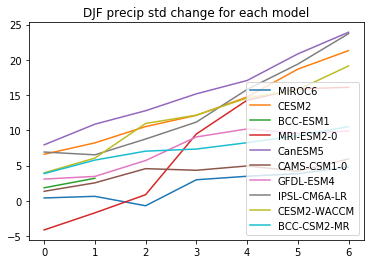

In [90]:
plt.plot((dsdG_djf_np-1)*100)
plt.title('DJF precip std change for each model')
plt.legend(modelnames)

Text(0, 0.5, 'Precip change (%)')

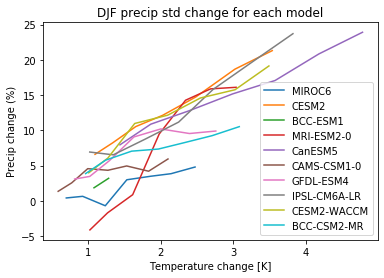

In [94]:
plt.plot(dt,(dsdG_djf_np-1)*100)
plt.title('DJF precip std change for each model')
plt.legend(modelnames)
plt.xlabel('Temperature change [K]')
plt.ylabel('Precip change (%)')


# Needed: get rid of models with NaNs before taking the multi-model mean

In [104]:
for i in range(10):
    print(modelnames[i])
    print(dt[:,i])
    print(dsdG_djf_np[:,i])
    print

MIROC6
[0.69760358 0.92414077 1.23591328 1.53334468 1.86146229 2.14341351
 2.47539063]
[1.00410916 1.00642759 0.99304771 1.02991738 1.03489617 1.03853684
 1.04800955]
CESM2
[1.0943906  1.33759377 1.65694182 2.02734797 2.48502429 3.02513154
 3.54099501]
[1.06604557 1.08227811 1.10538793 1.12134327 1.14736634 1.18681991
 1.21315694]
BCC-ESM1
[1.08017615 1.28208879        nan        nan        nan        nan
        nan]
[1.01855125 1.03201613        nan        nan        nan        nan
        nan]
MRI-ESM2-0
[1.02391869 1.26783705 1.61427509 1.98043718 2.34385808 2.68977643
 3.04222358]
[0.95877213 0.98300485 1.00873414 1.09488765 1.14275303 1.1588908
 1.16111286]
CanESM5
[1.43862323 1.86378497 2.39486586 2.99647037 3.57941802 4.18496177
 4.7870368 ]
[1.07952093 1.10878608 1.12788947 1.1518364  1.17073651 1.20848359
 1.23922087]
CAMS-CSM1-0
[0.58557645 0.77298177 0.99394305 1.27233195 1.53131223 1.83411814
 2.10157417]
[1.01353749 1.02556207 1.04568893 1.04339748 1.04951387 1.04204886
 

In [107]:
np.nanmean(dt,axis=1)

array([0.97267111, 1.23293357, 1.5803027 , 1.97306415, 2.37773672,
       2.80401369, 3.23506764])

In [111]:
np.nanmean((dsdG_djf_np-1)*100,axis=1)

array([ 3.19218341,  4.56547535,  6.73334441,  9.3212659 , 11.4861159 ,
       13.0496287 , 15.04240273])

Text(0, 0.5, 'Precip change (%)')

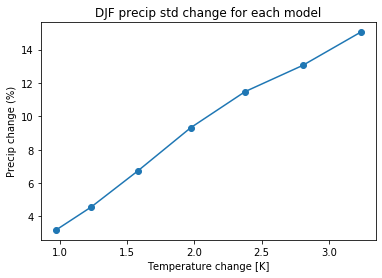

In [113]:
plt.plot(np.nanmean(dt,axis=1),np.nanmean((dsdG_djf_np-1)*100,axis=1),marker='o')
plt.title('DJF precip std change for each model')
plt.xlabel('Temperature change [K]')
plt.ylabel('Precip change (%)')